In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Getting image data

In [2]:
import pathlib
import os

In [3]:
data_dir = 'data'

# Defining model parameters

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1033 files belonging to 3 classes.
Using 827 files for training.
Found 1033 files belonging to 3 classes.
Using 206 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)


['banana', 'lemon', 'unknown']


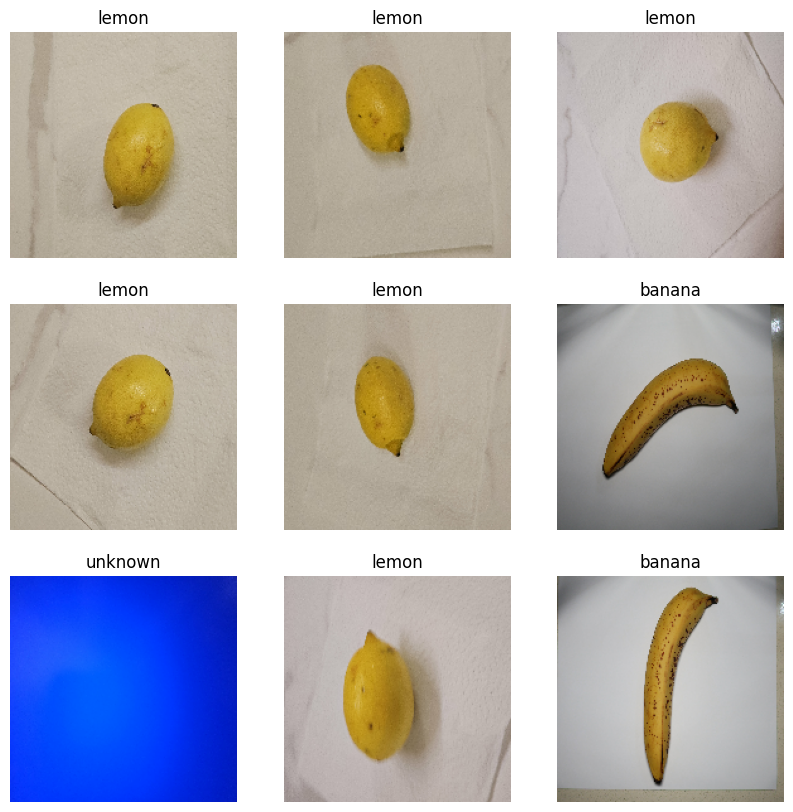

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
normalization_layer = layers.Rescaling(1./255)


In [10]:
# data augmentation to reduce overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


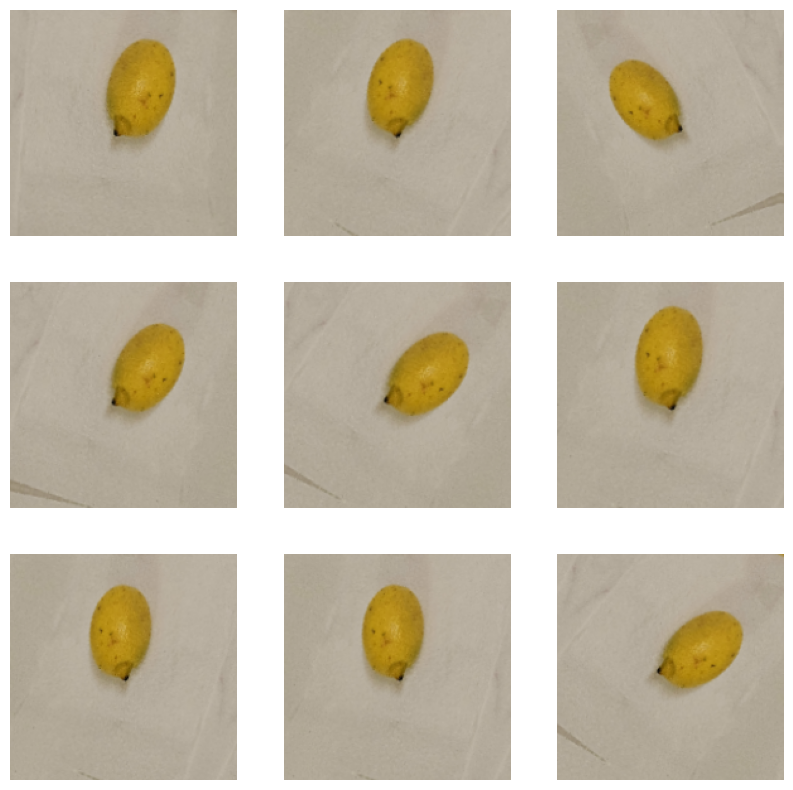

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [12]:
# creating model
# re-scalling is done within the model building process already

num_classes = len(class_names)

# Applying Dropout to the model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [14]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15


26/26 [==============================] - 6s 188ms/step - loss: 0.8276 - accuracy: 0.6469 - val_loss: 0.3273 - val_accuracy: 0.9369
Epoch 2/15
26/26 [==============================] - 3s 123ms/step - loss: 0.2368 - accuracy: 0.9166 - val_loss: 0.0833 - val_accuracy: 0.9660
Epoch 3/15
26/26 [==============================] - 3s 122ms/step - loss: 0.0738 - accuracy: 0.9722 - val_loss: 0.0717 - val_accuracy: 0.9854
Epoch 4/15
26/26 [==============================] - 3s 127ms/step - loss: 0.0896 - accuracy: 0.9879 - val_loss: 0.0295 - val_accuracy: 0.9903
Epoch 5/15
26/26 [==============================] - 3s 129ms/step - loss: 0.0659 - accuracy: 0.9758 - val_loss: 0.0230 - val_accuracy: 0.9951
Epoch 6/15
26/26 [==============================] - 3s 127ms/step - loss: 0.0247 - accuracy: 0.9940 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/15
26/26 [==============================] - 3s 128ms/step - loss: 0.0094 - accuracy: 0.9988 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoc

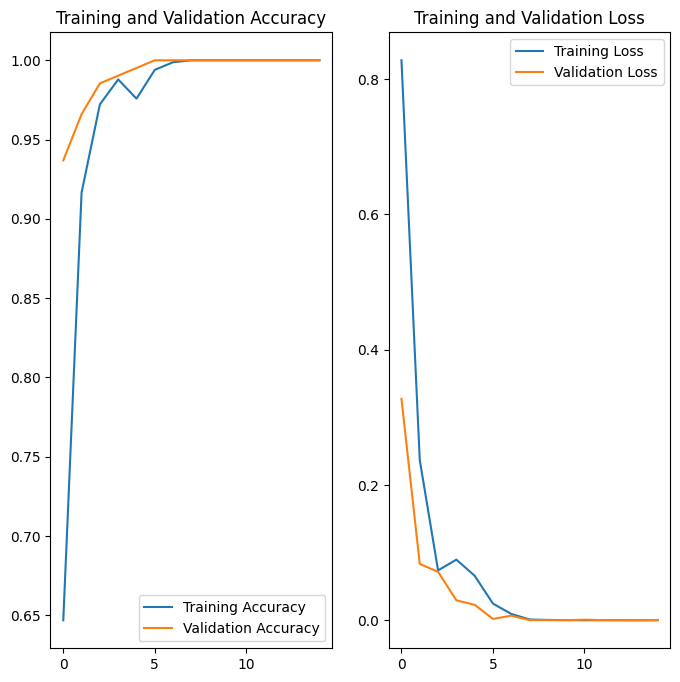

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Saving the model

In [17]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')


C:\Users\Ryan Chan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predicting on new data

In [18]:
# import time

In [19]:
# this works! Tha means if we manage to livestream our camera to a specific url, then put the url in here,
# we should get a live response for what we classify it as.

# test_flower_url = 'http://192.168.1.11:4747/video'
# test_flower_path = tf.keras.utils.get_file(origin=test_flower_url)

# img = tf.keras.utils.load_img(
#     test_flower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )


In [20]:
# pip install pyautogui

In [21]:
# import pyautogui
# from matplotlib import pyplot as plt
# from matplotlib import image as mpimg

In [22]:
# while True:
#     myScreenshot = pyautogui.screenshot(region=(960,200, 700, 400))
#     myScreenshot.save('ss.png')
#     time.sleep(1)
#     # print("Screenshot saved")

#     # plt.title("Screenshot Image")
#     # plt.xlabel("X pixel scaling")
#     # plt.ylabel("Y pixels scaling")
     
#     # image = mpimg.imread("ss.png")
#     # plt.imshow(image)
#     # plt.show()

#     test_flower_url = 'file:///C:/Users/Ryan%20Chan/MLAI%20Jupyter%20notebooks/TensorFlow%20Tutorial/ss.png'
#     test_flower_path = tf.keras.utils.get_file(origin=test_flower_url)
    
#     img = tf.keras.utils.load_img(
#         test_flower_path, target_size=(img_height, img_width)
#     )
#     img_array = tf.keras.utils.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0) # Create a batch
    
#     predictions = model.predict(img_array)
#     score = tf.nn.softmax(predictions[0])
    
#     print(
#         "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
#     )

In [23]:
# myScreenshot = pyautogui.screenshot(region=(960,200, 700, 400))
# myScreenshot.save('ss.png')

# time.sleep(1)

# test_flower_url = 'file:///C:/Users/Ryan%20Chan/MLAI%20Jupyter%20notebooks/TensorFlow%20Tutorial/test-banana.jpg'
# test_flower_path = tf.keras.utils.get_file(origin=test_flower_url)

# img = tf.keras.utils.load_img(
#     test_flower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
# .format(class_names[np.argmax(score)], 100 * np.max(score))
# )